# Parallel Computing

Julia has first class support for parallel computing which is becoming increasingly useful with the trend of increasing core counts, access to high performance clusters, and ever more performant GPU technology. In this workbook we will aim to cover the basic concepts of code parallelisation as well as several methods for parallelising code in Julia.

There are two major paradigms for parallel computing: CPU based and GPU based. The CPU based computing paradigm takes several CPU cores and links them together with a control node. The GPU paradigm allows the CPU to load data and code onto a specialised hardware unit, a graphics card, which has many available computing cores (that run at a lower clock speed) which allows for massive speed up of easily parallelisable operations such as matrix calculations.

## 1.0 CPU Based Parallelisation

CPU based parallelisation is controlled through the Distributed package in Julia. To use it we first need to load it and then make additional processes available to Julia through the ``addprocs`` function. This lets the Distributed package distribute the workload over a number of cores. It will still work without adding any processes as there is still one process that Julia is running on, but there isn't much point.

In [1]:
using Distributed, BenchmarkTools
addprocs(2)

2-element Vector{Int64}:
 2
 3

### 1.1 @distributed

The distributed macro is the easiest way to parallelise a ``for`` loop. 

In [2]:
@distributed for i = 1:10
    println("This is iteration $(i) performed on worker $(myid())")
end

Task (runnable) @0x00007fb6097192c0

Now lets perform a trivial task where we compute the function $f(x) = \sin(x) + \cos(x)$ for every integer up until 100 million. We will do this using a distritbued for loop and a regular for loop. To get the correct timing for the distributed for loop we have to sync up all of our active threads which we will do using the ``@sync`` macro. We wont record this result anywhere so it's rather wasteful.

In [3]:
@time for i = 1:10^8
    sin(i) + cos(i)
end

  4.476269 seconds
      From worker 2:	This is iteration 1 performed on worker 2
      From worker 2:	This is iteration 2 performed on worker 2
      From worker 2:	This is iteration 3 performed on worker 2
      From worker 2:	This is iteration 4 performed on worker 2


In [4]:
@time @sync @distributed for i = 1:10^8
    sin(i) + cos(i)
end

      From worker 2:	This is iteration 5 performed on worker 2
      From worker 3:	This is iteration 6 performed on worker 3
      From worker 3:	This is iteration 7 performed on worker 3
      From worker 3:	This is iteration 8 performed on worker 3
      From worker 3:	This is iteration 9 performed on worker 3
      From worker 3:	This is iteration 10 performed on worker 3
  2.571765 seconds (78.08 k allocations: 3.778 MiB, 1.95% compilation time: 28% of which was recompilation)


Task (done) @0x00007fb60a2159f0

We got an almost perfect 2x speed up. That corresponds quite well with the number of processes that we have allocated to Julia. If we wanted a 4x speed up we can add two more process. Again, we will see the process time is halved.

In [5]:
addprocs(2)

2-element Vector{Int64}:
 4
 5

In [6]:
@time @sync @distributed for i = 1:10^8
    sin(i) + cos(i)
end

  2.234233 seconds (71.66 k allocations: 3.500 MiB, 1.20% compilation time)


Task (done) @0x00007fb60bdbf260

#### 1.1.1 Synchronisation. 
A small aside here is to think about syncronisation when timing mulitple processes. The @time macro reports the time for a function to be dispatched and the working thread to be available to run another process. In this case the master thread is simply dishing out work to multiple processor but not doing any of it itself. Therefore, to time it properly we have to sync all these threads and wait for them to report their results and this is what the @sync macro does. Syncronisation is an important part of benchmarking high performance tasks and neglecting it will result in some very optimistic timing. Let's remove the @sync macro.

In [7]:
@time @distributed for i = 1:10^8
    sin(i) + cos(i)
end

  0.006020 seconds (7.00 k allocations: 373.918 KiB, 99.06% compilation time)


Task (runnable) @0x00007fb839df26e0

### 1.3 Shared Packages and Functions: @everywhere 
Suppose we are interested in the random variable $Z \sim \sin(X) + \cos(X)$ where $X \sim U([0,1])$. We would like to know roughly how many samples it takes to a reasonable estimate of the mean. To do this we might write a simple function to calculate the mean and run a for loop which generates succesively larger samples of random numbers. We know that this will take a while so we want to parallelise it to speed things up.

In [8]:
function custom_mean(x::Array{Float64,1})
    return sum(x) / length(x)
end

@distributed for i = 1:250
    X = rand(i);
    Z = sin.(X) + cos.(X)
    res = custom_mean(Z)
end

Task (runnable) @0x00007fb83a083540

This results in an error. Each time we add a new process we are essentially starting up a new Julia enviroment and so these processes wont know about any custom functions or functions imported from packages. The Julia base packages will be available to the new threads, but it is likely we will go further than these. To let the threads know about new functions we make use of the ``@everywhere`` macro.

In [9]:
@everywhere function distributed_custom_mean(x::Array{Float64,1})
    return sum(x) / length(x)
end

@distributed for i = 1:250
    X = rand(i);
    Z = sin.(X) + cos.(X)
    res = distributed_custom_mean(Z)
end

Task (runnable) @0x00007fb60a216850

The ``@everywhere`` macro applies equally well to packages. Let's try it out with the StatsBase package.

In [10]:
@everywhere using StatsBase

@distributed for i = 1:250
    X = rand(i);
    Z = sin.(X) + cos.(X)
    res_av = mean(Z)
    res_std = std(Z)
end

Unhandled Task ERROR: On worker 2:
UndefVarError: #custom_mean not defined
Stacktrace:
  [1] deserialize_datatype
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Serialization/src/Serialization.jl:1364
  [2] handle_deserialize
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Serialization/src/Serialization.jl:866
  [3] deserialize
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Serialization/src/Serialization.jl:813
  [4] handle_deserialize
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Serialization/src/Serialization.jl:873
  [5] deserialize
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Serialization/src/Serialization.jl:813 [inlined]
  [6] deserialize_global_from_main
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Distributed/src/clusterserialize.jl:160
  [7] #5
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Distributed/src/clusterserialize.jl:72 [inlined]
  [8] foreach
    @ ./abstractarray.jl:2774
  [9] deserialize
    @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Distributed/src/cluster

Task (runnable) @0x00007fb83b0726e0

### 1.3 Shared memory

Performing a calculation solely in a loop is not very useful. More often than not we will want to write some data that arises from the calculation to a memory address so that we can access it later. Let's try and naively write the results of our last calculation into a results vector.

In [11]:
L = 250
res_av = zeros(L)
res_std = zeros(L)
@distributed for i = 1:L
    X = rand(i);
    Z = sin.(X) + cos.(X)
    res_av[i] = mean(Z)
    res_std[i] = std(Z)
end
println(res_av)
println(res_std)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

This did not work. The reason is because each of the threads that we intialised did not have access to the ``res`` vector; it was exclusively owned by the thread that created it. To get around this we need memory that is *shared*.

The concept of shared memory is very important in parallel computing: the individual processes do not know about each other and typically do not have access to each others data. Sharing data, and indeed modifying data after the result of a computation, is tricky with parallel computing because the threads handle operations *asynchronolously* and if two parallel threads try and access the same bit of shared memory at the same time this can lead to a *race* condition. Race conditions are one of the most common (and frustrating) sources of error in parallel computation paradigms. Shared memory is handled in Julia via SharedArrays and deals with many of the nasty gotcha's in the parallel computation setup. Let's create a SharedArray and modify it.

In [12]:
@everywhere using SharedArrays

In [13]:
res_shared_av = SharedArray(zeros(L))
res_shared_std = SharedArray(zeros(L))
@sync @distributed for i = 1:L
    X = rand(i)
    Z = sin.(X) + cos.(X)
    res_shared_av[i] = mean(Z)
    res_shared_std[i] = std(Z)
end
println(res_shared_av)
println(res_shared_std)

[1.3507768204270891, 1.3964171290885194, 1.1584675196198997, 1.3977156502574246, 1.2742749948039935, 1.258662186094655, 1.286060364465411, 1.3073484254470136, 1.2673255111489887, 1.306501040171104, 1.3389819126712985, 1.3487564959693223, 1.3352083336321459, 1.2856325027821744, 1.339743609462649, 1.252744171385895, 1.2745508544466506, 1.2995467027524135, 1.3093245300422776, 1.259480396947157, 1.2990077890767395, 1.2825572629571937, 1.3012847616209033, 1.3044621236387146, 1.3159916046884481, 1.2648059344067792, 1.3319201842237045, 1.2434551383282204, 1.3381040178091892, 1.2863133965368454, 1.276274227568296, 1.3261925850782021, 1.3140821323813818, 1.3136389815527485, 1.3135022349723744, 1.3090176533053943, 1.3040625574056541, 1.3070111686887107, 1.321288899957135, 1.3235310855943887, 1.3122566906271358, 1.304492349896226, 1.3028736685046851, 1.2954565428744584, 1.286525026564539, 1.28260593731729, 1.271376221679689, 1.298537688947196, 1.3029290647805603, 1.3016323790242785, 1.29051692932

That is looking much more realistic. Now we can plot the results to get a intiutive feel about how long many samples we require from this complicated distribution to get a reasonable estimate about these statistics. It seems that 150 will be sufficient for most purposes!

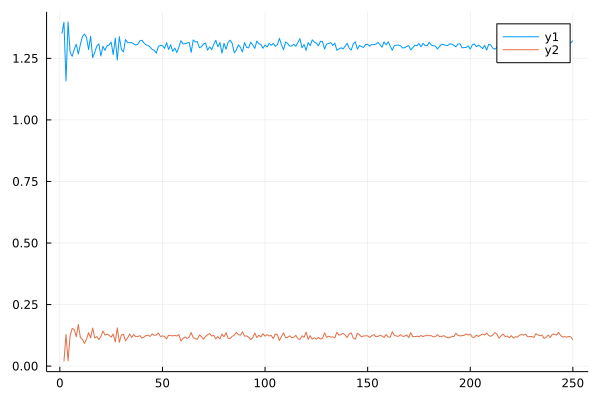

In [14]:
using Plots
plot(1:L, [res_shared_av, res_shared_std])

### 1.4 Functional Parallelisation: pmap

The most intuitive way to interact with the Distributed package is through the use of the ``pmap`` function which works precisely the same way as the ``map`` function applying some operation through an iterable list. The function is nice because it automatically stores the result of the anonymous function into the memory address asscociated with the index of the vector we are mapping the function onto; we do not need to worry about shared memory. Let's try out with a simple function to show which thread we are excecuting on.

In [15]:
pmap(x -> myid(), 1:10)

10-element Vector{Int64}:
 2
 3
 4
 5
 4
 4
 4
 4
 4
 4

Now let's try and do the previous task instead using ``pmap``. We will compare them by eyeballing the plots but a more comprehensive comparison would involve 

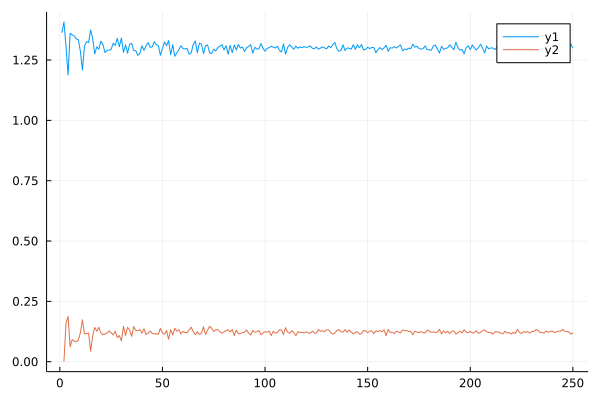

In [16]:
samples = [rand(i) for i = 1:250];
map_av = pmap(x -> mean(sin.(x) .+ cos.(x)), samples)
map_std = pmap(x -> std(sin.(x) .+ cos.(x)), samples)
plot(1:250, [map_av, map_std])

The final thing we need to do is compare the times against the regular unparallel

In [17]:
@btime pmap_av = pmap(x -> mean(sin.(x) .+ cos.(x)), samples);
@btime map_av = map(x -> mean(sin.(x) .+ cos.(x)), samples);

  5.846 ms (13082 allocations: 785.09 KiB)
  297.309 μs (252 allocations: 272.23 KiB)


Shockingly, we didn't see a substantial speed-up compared to the CPU even though the @distributed loop did offer a speed-up. The reason is because quite a lot of work goes on behind the scene setting the stage for ``pmap`` to do its own work. This is a classic problem in high performance computing - the startup time (or development time) of significantly more complex code might be more than just running the program in the traditional manner. This demonstrates that ``pmap`` works best when the workloads given to it are complex in each thread and justify the high start up time. Computing the sum of the eigenvalues of a large matrix is quite a difficult task. Let's see how the different methods of computing them compare.

In [32]:
@everywhere using LinearAlgebra
@everywhere function distributed_eigenvalues(mats)
    L = length(mats)
    res = SharedArray(Vector{ComplexF64}(zeros(L)))
    @distributed for i = 1:L
        res[i] = sum(eigvals(mats[i]))
    end
    return res
end

In [19]:
mats = [rand(10^3,10^3) for i = 1:10];

In [20]:
@btime map(x -> sum(eigvals(x)), mats)

  7.346 s (142 allocations: 79.36 MiB)


10-element Vector{ComplexF64}:
 499.04052602604037 + 7.172040739078511e-14im
   494.382144887218 + 1.0880185641326534e-14im
 509.63674225239885 - 2.1471713296250527e-13im
 474.49387867130434 + 1.4876988529977098e-14im
  471.9506064609294 + 7.549516567451064e-14im
 492.12361420115474 + 1.0547118733938987e-13im
 498.07058634929257 - 1.127986593019159e-13im
  483.8457982883142 + 0.0im
  510.3601348624554 + 1.1368683772161603e-13im
 492.30995881787453 - 3.6415315207705135e-14im

In [21]:
@btime pmap(x -> sum(eigvals(x)), mats)

  1.398 s (735 allocations: 29.34 KiB)


10-element Vector{ComplexF64}:
 499.04052602603866 + 3.530509218307998e-14im
  494.3821448872144 + 3.3084646133829665e-14im
 509.63674225239697 - 1.1102230246251565e-15im
  474.4938786713037 - 1.3100631690576847e-14im
 471.95060646093106 - 2.353672812205332e-14im
  492.1236142011547 + 7.593925488436071e-14im
  498.0705863492945 - 6.705747068735946e-14im
  483.8457982883135 + 0.0im
  510.3601348624573 - 2.842170943040401e-14im
 492.30995881787464 + 4.263256414560601e-14im

In [33]:
@btime distributed_eigenvalues(mats)

  1.393 s (1154 allocations: 52.90 KiB)


10-element SharedVector{ComplexF64}:
 499.04052602603866 + 3.530509218307998e-14im
  494.3821448872144 + 3.3084646133829665e-14im
 509.63674225239697 - 1.1102230246251565e-15im
  474.4938786713037 - 1.3100631690576847e-14im
 471.95060646093106 - 2.353672812205332e-14im
  492.1236142011547 + 7.593925488436071e-14im
  498.0705863492945 - 6.705747068735946e-14im
  483.8457982883135 + 0.0im
  510.3601348624573 - 2.842170943040401e-14im
 492.30995881787464 + 4.263256414560601e-14im

Here we see that there is a substantial speed up when parallelising. Notably, there is very little difference between the ``@distributed`` and ``pmap`` methods. The latter method is more elegant: it requires less code, is more comprehensible, and does not have an additional package depenedency. When the workload is complex ``pmap`` is recommended (even if for readability alone). 

## GPU Based Parallelisation
Julia has excellent GPU support in the GPUArrays package which forms the basis for packages to interface with specific cards. The two major GPU companies are AMD and nVidia which are supported through the AMDGPU and CUDA packages respectively. There is also support for ArrayFire and Vulkan. Finally, the Metal package is being developed to interact with Apple's Metal API to unlock support for the new Apple SoCs but this is experimental. Fundamentally, the GPU packages work in similar ways. 

The most common method of interfacing with the GPU is through an array constructor: CuArray or ROCArray for Nvidia 
and AMD respectively. From there the multiple dispatch system has most functions covered and will automatically compile the GPU code from native Julia code. For example, let's run a simple element wise multiplication on an Nvidia GPU.

In [23]:
using CUDA
CUDA.device!(1)

CuDevice(1): NVIDIA GeForce RTX 3090

In [24]:
a_cpu = rand(Float32, 10^7);
b_cpu = rand(Float32, 10^7);
a_gpu = CuArray(a_cpu);
b_gpu = CuArray(b_cpu);

In [25]:
@btime a_cpu .* b_cpu;

  13.077 ms (4 allocations: 38.15 MiB)


In [26]:
@btime CUDA.@sync a_gpu .* b_gpu;

  155.392 μs (32 allocations: 1.83 KiB)


This is a substantial speed-up! On my GPU it went from 11ms to 157us which is approximately 70 times faster, but your mileage may vary depending on your hardware and drivers. We should check that the result is consistent with the CPU which we know to be accurate (if a little slow). In general, it is good practice to write a small minimal working example that can run quickly on both the CPU and GPU to check that you get the same result before running the large computation on the GPU.

In [27]:
res_cpu = a_cpu .* b_cpu;
res_gpu = a_gpu .* b_gpu;
res_cpu == Array(res_gpu)

true

### 2.1 Float32 vs Float64

You may have noticed that we specified Float32 as the data type for the random vector --- this is a little odd because traditional scientific computing (and the Julia default) uses Float64. We do this because GPU's are best optimised for Float32 operations. They can handle Float64 operations fine, and you will still get a speed up, but it wont be as substantial. Some calculations require Float64 precision though, and if this is the case you must use it otherwise you will get inaccurate results. Let's try a Float64 operation using a native CUDA constructor:

In [28]:
L = 10^4
c1_gpu = CUDA.rand(Float32, L, L);
d1_gpu = CUDA.rand(Float32, L, L);
t1 = @elapsed CUDA.@sync (c1_gpu * d1_gpu);
println("The Float32 time is $(t1)");

c2_gpu = CUDA.rand(Float64, L, L);
d2_gpu = CUDA.rand(Float64, L, L);
t2 = @elapsed CUDA.@sync (c2_gpu * d2_gpu);
println("The Float64 time is $(t2)");

The Float32 time is 1.575633762
The Float64 time is 3.814508414


There is a notable performance difference between the two types. While it is not a substantial real-time difference for a single matrix multiplication if you are expected to do many hundreds of thousands of them the performance gap will incur a substantial penalty. Many deep learning models require substantial matrix multiplication calls and accordingly use Float32 data to not incur the time penatly (under the assumption that their numerics are sufficiently stable that Float32 operations dont incur significant error).

### 2.2 Supported functional programming

In [29]:
Some matrix operations - not matrix factorisation
sums
reduce operations
map works quite well



LoadError: syntax: extra token "matrix" after end of expression

### 2.3 Custom Kernels